<a href="https://colab.research.google.com/github/hibaessid/Multi-Modal-OCR-for-ID-Classification-in-Insurance-Documents/blob/main/OCR_classificationOfInsuranceDocs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torchvision

In [3]:
# Import necessary libraries
import matplotlib.pyplot as plt
import numpy as np
from project_utils import ProjectDataset
import pickle
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim


In [4]:
# Load the OCR insurance dataset
try:
    dataset = pickle.load(open('ocr_insurance_dataset.pkl', 'rb'))
    print("Dataset loaded successfully!")
except FileNotFoundError:
    print("Dataset file not found. Ensure 'ocr_insurance_dataset.pkl' is in the working directory.")


Dataset loaded successfully!


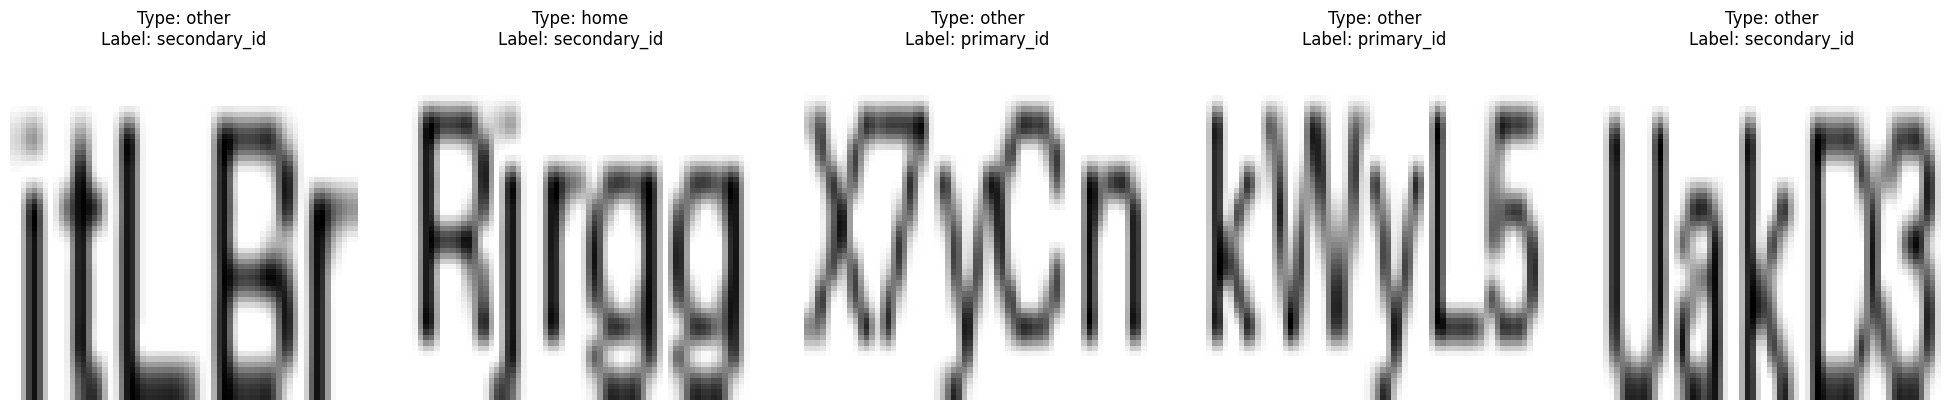

In [5]:
# Define a function to visualize dataset images with their types and labels
def show_dataset_images(dataset, num_images=5):
    """
    Visualizes random images from the dataset along with their types and labels.

    Parameters:
        dataset: The dataset object containing images, types, and labels.
        num_images: The number of images to visualize (default: 5).
    """
    fig, axes = plt.subplots(1, min(num_images, len(dataset)), figsize=(20, 4))

    for ax, idx in zip(axes, np.random.choice(len(dataset), min(num_images, len(dataset)), False)):
        img, lbl = dataset[idx]  # Extract image and label
        # Rescale image values for visualization
        img_array = (img[0].numpy() * 255).astype(np.uint8).reshape(64, 64)
        # Retrieve type and label names
        img_type = list(dataset.type_mapping.keys())[img[1].tolist().index(1)]
        label_name = list(dataset.label_mapping.keys())[list(dataset.label_mapping.values()).index(lbl)]
        # Plot image
        ax.imshow(img_array, cmap='gray')
        ax.axis('off')
        ax.set_title(f"Type: {img_type}\nLabel: {label_name}")

    plt.tight_layout()
    plt.show()

# Visualize 5 random samples from the dataset
show_dataset_images(dataset, num_images=5)


In [6]:
# Define the OCRModel
class OCRModel(nn.Module):
    def __init__(self, image_size=(64, 64), num_types=5, num_classes=2):
        super(OCRModel, self).__init__()

        # Image processing layers (CNN)
        self.image_layer = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output: (16, 32, 32)
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output: (32, 16, 16)
            nn.Flatten(),  # Flatten for the fully connected layer
        )

        # Compute the flattened output size from image_layer
        img_output_size = (image_size[0] // 4) * (image_size[1] // 4) * 32

        # Type embedding (categorical input)
        self.type_embedding = nn.Embedding(num_types, 8)  # Embedding for type input

        # Combined processing layers
        self.fc = nn.Sequential(
            nn.Linear(img_output_size + 8, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes),
        )

    def forward(self, image, type_input):
        # Process image through CNN
        img_features = self.image_layer(image)

        # Process type through embedding
        type_features = self.type_embedding(type_input)

        # Combine features and pass through FC layers
        combined = torch.cat((img_features, type_features), dim=1)
        output = self.fc(combined)
        return output

# Instantiate the model
model = OCRModel()


In [7]:
# Define a dummy dataset for demonstration
class InsuranceDataset(Dataset):
    def __init__(self, num_samples=1000, image_size=(64, 64)):
        self.num_samples = num_samples
        self.image_size = image_size

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        # Generate random grayscale images and labels
        image = torch.rand(1, *self.image_size)  # Grayscale image
        type_input = torch.randint(0, 5, (1,))  # Random type (0-4)
        label = torch.randint(0, 2, (1,)).item()  # Random label (0 or 1)
        return image, type_input.squeeze(), label

# Create the dataset and dataloader
dataset = InsuranceDataset()
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)


In [8]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [10]:
# Training Loop
epochs = 10
# Training Loop with Loss Tracking
loss_history = []  # To store loss per epoch

for epoch in range(epochs):
    total_loss = 0
    for images, types, labels in train_loader:
        labels = labels.long()  # Ensure labels are LongTensor for CrossEntropyLoss
        optimizer.zero_grad()  # Clear previous gradients
        outputs = model(images, types)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights
        total_loss += loss.item()

    epoch_loss = total_loss / len(train_loader)
    loss_history.append(epoch_loss)  # Append epoch loss
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss:.4f}")



Epoch 1/10, Loss: 0.6935
Epoch 2/10, Loss: 0.6931
Epoch 3/10, Loss: 0.6930
Epoch 4/10, Loss: 0.6943
Epoch 5/10, Loss: 0.6938
Epoch 6/10, Loss: 0.6930
Epoch 7/10, Loss: 0.6934
Epoch 8/10, Loss: 0.6934
Epoch 9/10, Loss: 0.6933
Epoch 10/10, Loss: 0.6932


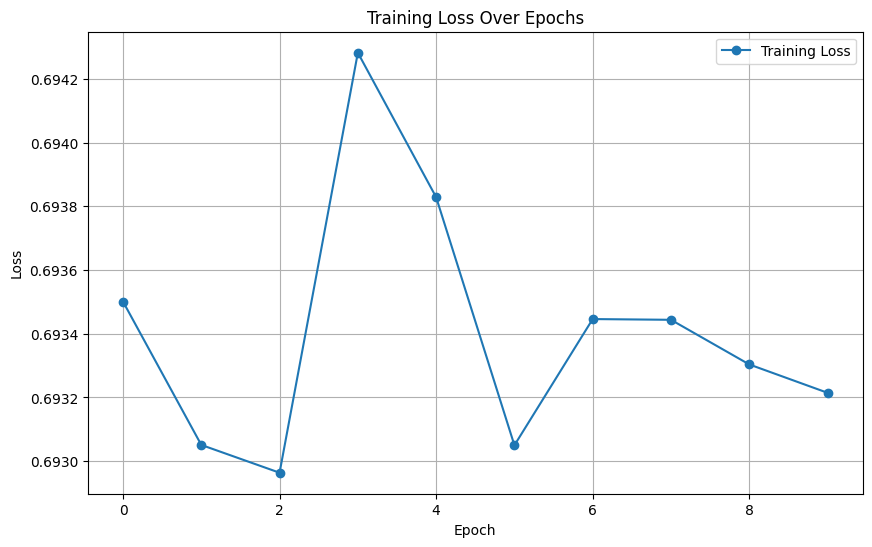

In [11]:
# Plot Training Loss
plt.figure(figsize=(10, 6))
plt.plot(loss_history, marker='o', label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()


In [13]:
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

def evaluate_model(model, data_loader):
    model.eval()  # Set model to evaluation mode
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, types, labels in data_loader:
            outputs = model(images, types)
            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.tolist())
            all_preds.extend(preds.tolist())

    # Calculate accuracy
    accuracy = accuracy_score(all_labels, all_preds)
    print(f"Accuracy: {accuracy:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Primary', 'Secondary'], yticklabels=['Primary', 'Secondary'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()


Accuracy: 0.5250


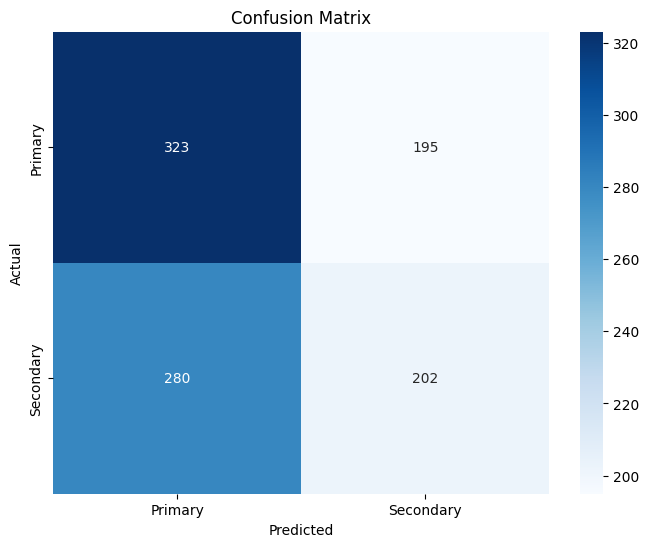

In [14]:
# Evaluate Model Performance
# Create a test set from the dataset (optional)
test_loader = DataLoader(dataset, batch_size=32, shuffle=False)

# Evaluate the model
evaluate_model(model, test_loader)
